<a href="https://colab.research.google.com/github/FrittatinaDiBucatini09/Stroke_Prediction_ML_Project/blob/main/stroke_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Programmazione di Applicazioni Data Intensive**

Ingegneria e Scienze Informatiche

**DISI** - Università di Bologna, campus di Cesena

Balzani Riccardo

# Descrizione del problema

I dataset in esame contengono informazioni cliniche di pazienti raccolte per la **previsione del rischio di ictus.** Le variabili includono dati demografici, condizioni mediche preesistenti, stili di vita e misurazioni cliniche rilevanti. I dataset presi in considerazione sono due:


1.   [***Stroke Prediction Dataset:***](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset) include variabili come stato civile e tipo di residenza (urbana/rurale), che potrebbero non essere strettamente cliniche ma utili per analisi socio-demografiche.


2.  [ ***Stroke Risk Prediction Dataset based on Literature:***](https://www.kaggle.com/datasets/mahatiratusher/stroke-risk-prediction-dataset-v2) progettato per applicazioni di intelligenza artificiale medica, potrebbe includere feature selezionate in base a studi recenti o linee guida cliniche.

L’obiettivo del progetto è sviluppare due modelli di classificazione binaria (uno per ogni dataset) che, a partire da queste informazioni, siano in grado di prevedere la probabilità di insorgenza di un ictus, al fine di supportare interventi preventivi efficaci e migliorare la gestione sanitaria dei pazienti.

# Preparazione dell'ambiente di lavoro

In [1]:
# Eseguire solo se non installata
!pip install colorama

In [2]:
import kagglehub
import os
from colorama import Fore
import pandas as pd
import numpy as np
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

###Caricamento delle directory contenenti i dataset

Le directory scaricate da *Kaggle* attraverso la funzione `kagglehub.dataset_download` conterranno i files associati al dataset in oggetto.
**Nota bene:** nel resto del notebook il dataset *Stroke Risk Prediction Dataset based on Literature* verrà indicato come ***Stroke Prediction v2***.

In [3]:
# Download Stroke Prediction Dataset
stroke_path = kagglehub.dataset_download("fedesoriano/stroke-prediction-dataset")
print("Path to dataset files:", stroke_path)

# Download Stroke Risk Prediction Dataset v2
stroke_v2_path = kagglehub.dataset_download("mahatiratusher/stroke-risk-prediction-dataset-v2")
print("Path to dataset files:", stroke_v2_path)

Path to dataset files: /kaggle/input/stroke-prediction-dataset


100%|██████████| 240k/240k [00:00<00:00, 67.6MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/mahatiratusher/stroke-risk-prediction-dataset-v2/versions/1


### Ricerca dei file csv nelle directory scaricate

In [4]:
# Looking for Stroke Prediction
for file in os.listdir(stroke_path):
    if file.endswith(".csv"):
        stroke_csv_path = os.path.join(stroke_path, file)
        df_stroke_stock = pd.read_csv(stroke_csv_path)
        print("Loaded Stroke Prediction Dataset")
        break

# Looking for Stroke Prediction v2
for file in os.listdir(stroke_v2_path):
    if file.endswith(".csv"):
        stroke_v2_csv_path = os.path.join(stroke_v2_path, file)
        df_stroke_v2_stock = pd.read_csv(stroke_v2_csv_path)
        print("Loaded Stroke Risk Prediction Dataset v2")
        break

Loaded Stroke Prediction Dataset
Loaded Stroke Risk Prediction Dataset v2


Shuffle dei dataset.

In [5]:
df_stroke = df_stroke_stock.sample(frac=1, random_state=42).reset_index(drop=True)
df_stroke_v2 = df_stroke_v2_stock.sample(frac=1, random_state=42).reset_index(drop=True)

# Analisi delle differenze dei due dataset

In [6]:
common_columns = df_stroke.columns.intersection(df_stroke_v2.columns).tolist()
unique_to_stroke = df_stroke.columns.difference(df_stroke_v2.columns).tolist()
unique_to_stroke_v2 = df_stroke_v2.columns.difference(df_stroke.columns).tolist()

print(Fore.GREEN + "\nColonne comuni:", common_columns)
print(Fore.RED + "Colonne uniche a df_stroke:", unique_to_stroke)
print(Fore.MAGENTA + "Colonne uniche a df_stroke_v2:", unique_to_stroke_v2)


Colonne comuni: ['gender', 'age']
Colonne uniche a df_stroke: ['Residence_type', 'avg_glucose_level', 'bmi', 'ever_married', 'heart_disease', 'hypertension', 'id', 'smoking_status', 'stroke', 'work_type']
Colonne uniche a df_stroke_v2: ['anxiety_doom', 'at_risk', 'chest_discomfort', 'chest_pain', 'cold_hands_feet', 'dizziness', 'excessive_sweating', 'fatigue_weakness', 'high_blood_pressure', 'irregular_heartbeat', 'nausea_vomiting', 'neck_jaw_pain', 'persistent_cough', 'shortness_of_breath', 'snoring_sleep_apnea', 'stroke_risk_percentage', 'swelling_edema']


Da questa analisi possiamo notare come:


1.   ***Stroke Prediction Dataset:*** ha molte colonne cliniche tradizionali come `hypertension, heart_disease, avg_glucose_level, smoking_status,` e la variabile `target stroke`, che sarà la **variabile target** per il modello di classificazione binaria. Altre colonne come `Residence_type, ever_married, work_type` sono socio-demografiche e possono essere utili per il modello pur non essendo presenti in *df_stroke_v2.*



2.   ***Stroke Prediction Dataset v2:*** risulta essere più orientato ai sintomi clinici (es. `chest_pain, dizziness, shortness_breath`) e non incorpora colonne cliniche come `hypertension` e `heart_disease,` che invece sono presenti in *df_stroke.* La colonna `at_risk` è identificabile come la **variabile target** per il modello di classificazione binaria.

E' possibile quindi che i due dataset possano evidenziare/ignorare parametri importanti per determinare il rischio di ictus di un paziente.
Risulta quindi ragionevole valutare il modello di classificazione sia su *Stroke Prediction Dataset* che su *Stroke Prediction Dataset v2*.


# Analisi di Stroke Prediction Dataset

In questa sezione si analizza il primo dataset ovvero ***Stroke Prediction Dataset.***

<font color="lightgreen">Il dataset è reperibile qui </font> [Kaggle](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset).

### Data Exploration

In [7]:
df_stroke.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,40041,Male,31.0,0,0,No,Self-employed,Rural,64.85,23.0,Unknown,0
1,55244,Male,40.0,0,0,Yes,Self-employed,Rural,65.29,28.3,never smoked,0
2,70992,Female,8.0,0,0,No,children,Urban,74.42,22.5,Unknown,0
3,38207,Female,79.0,1,0,Yes,Self-employed,Rural,76.64,19.5,never smoked,0
4,8541,Female,75.0,0,0,Yes,Govt_job,Rural,94.77,27.2,never smoked,0


Il dataset *Stroke Prediction Dataset* contiene le seguenti feature, come evidenziato dalla prima visualizzazione:

* `id:` identificativo univoco di ciascun paziente (feature da rimuovere in fase di preprocessing).
* `gender:` genere del paziente (Maschio/Femmina/Other).
* `age:` età espressa in anni.
* `hypertension:` presenza o assenza di ipertensione (binaria, 0/1).
* `heart_disease:` presenza o assenza di malattie cardiache (binaria, 0/1).
* `ever_married:` stato civile (Sì/No).
* `work_type:` tipologia di lavoro (categorie come Private, Self-employed, ecc.).
* `Residence_type:` tipo di residenza (Urban/Rural).
* `avg_glucose_level:` livello medio di glucosio nel sangue.
* `bmi:` indice di massa corporea (con alcuni valori mancanti da imputare).
* `smoking_status:` stato del fumo (es. never smoked, formerly smoked, smokes).
* `stroke:` variabile target, indica se il paziente ha avuto un ictus (1) o no (0).


In [8]:
df_stroke.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Si pone l'attenzione su una serie di dati:


1.   <u>**Valori mancanti:**</u>
*  ` bmi`: mostra 201 valori assenti, circa il 3.9% del totale.

2. <u>**Possibili outlier:**</u>
*   `age`: minimo 0.08 anni, circa un mese d'età, probabilmente si tratta di un errore.
* `bmi` massimo 97.6 kg/m² e `avg_glucose_level` massimo 271.7 mg/dL. Si tratta di valori estremi che potrebbero distorcere le statistiche.

3. <u>**Distribuzione delle comorbidità:**</u>
* Ipertensione, circa 10 %, e malattie cardiache, circa 5 %, sono relativamente rare ma potenzialmente molto informative per la predizione.

4. <u>**Età e fattori metabolici:**</u>
* Età mediana 45 anni e media glicemica 106 mg/dL suggeriscono una popolazione eterogenea, con parte dei soggetti a rischio metabolico.

In [9]:
# Calculating the balance of the target stroke variable
def target_balance (target, dataset):
  print("Valori unici di '" + target + "':", dataset[target].unique())

  absolute_distribution = dataset[target].value_counts()
  print("\nDistribuzione assoluta di '" + target + "':")
  print(absolute_distribution)

  relative_distribution = dataset[target].value_counts(normalize=True) * 100
  print(Fore.BLUE + "\nDistribuzione relativa di " + target + " (in %):")
  print(relative_distribution)

  if relative_distribution.min() < 40:
    print(Fore.RED + "\nIl dataset è sbilanciato.")
  else:
    print(Fore.GREEN + "\nIl dataset è bilanciato.")

target_balance('stroke', df_stroke)

Valori unici di 'stroke': [0 1]

Distribuzione assoluta di 'stroke':
stroke
0    4861
1     249
Name: count, dtype: int64

Distribuzione relativa di stroke (in %):
stroke
0    95.127202
1     4.872798
Name: proportion, dtype: float64

Il dataset è sbilanciato.


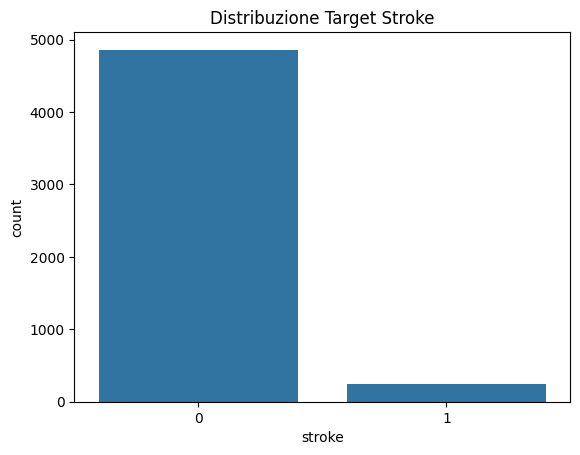

In [10]:
sns.countplot(x='stroke', data=df_stroke)
plt.title("Distribuzione Target Stroke")
plt.show()

Solamente il 4.872798% dei pazienti presenti nel dataset presenta la variabile `stroke=1`.

In [11]:
# Count missing values ​​for each column
missing_values = df_stroke.isna().sum()
print("Valori mancanti per colonna:")
print(missing_values)

# Calculate the percentage of missing values ​​per column
missing_percentage = (df_stroke.isna().sum() / len(df_stroke)) * 100
print("\nPercentuale di valori mancanti per colonna:")
print(missing_percentage)

Valori mancanti per colonna:
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Percentuale di valori mancanti per colonna:
id                   0.000000
gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
bmi                  3.933464
smoking_status       0.000000
stroke               0.000000
dtype: float64


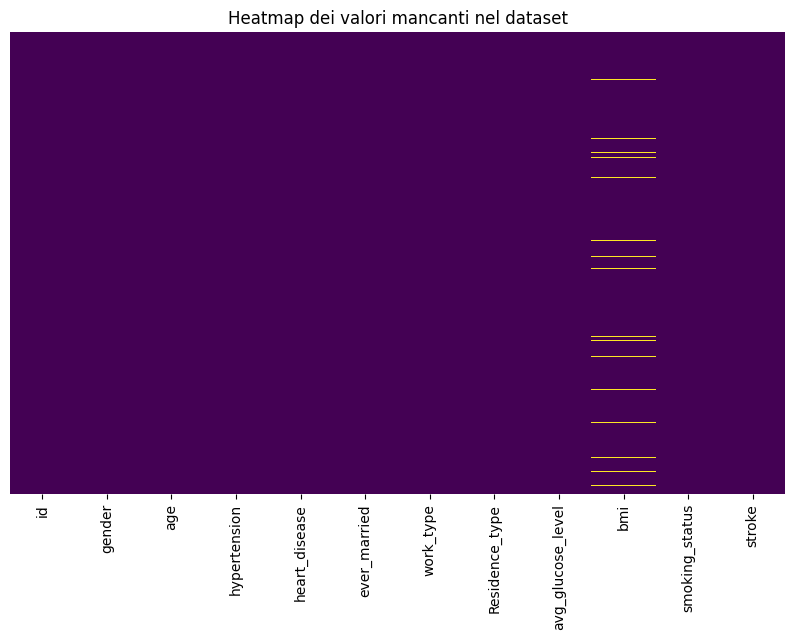

In [12]:
def heat_map_NaN(dataset):
  plt.figure(figsize=(10, 6))
  sns.heatmap(dataset.isna(), cbar=False, cmap='viridis', yticklabels=False)
  plt.title("Heatmap dei valori mancanti nel dataset")
  plt.show()

heat_map_NaN(df_stroke)

In [13]:
# Count occurrences of values ​​in column 'gender'
gender_counts = df_stroke['gender'].value_counts()

# Calculate the total number of rows
total_rows = len(df_stroke)

# Calculate the percentage of 'Other'
other_count = gender_counts.get('Other', 0)
other_percentage = (other_count / total_rows) * 100

# Print the result
print(f"Numero di 'Other' in 'gender': {other_count}")
print(Fore.RED + f"Percentuale di 'Other' in 'gender': {other_percentage:.5f}%")

Numero di 'Other' in 'gender': 1
Percentuale di 'Other' in 'gender': 0.01957%


In fase di preprocessing, sarà necessario:

1. Rimuovere la colonna `id` in quanto non informativa per la modellazione.
2. Gestire i valori mancanti nella colonna `bmi`, ad esempio con imputazione tramite mediana.
3. Rimuovere l'unica occorrenza di *Other* nella colonna `gender`.

4. Codificare le variabili categoriche tramite tecniche come *One-Hot Encoding.*
5. Bilanciare il dataset in considerazione dello sbilanciamento naturale della variabile target stroke (circa 5% positivi).

La variabile target `stroke` è binaria e indica la presenza di un ictus. Si osserva uno sbilanciamento significativo, che rende necessario l’impiego di tecniche di bilanciamento come SMOTE.

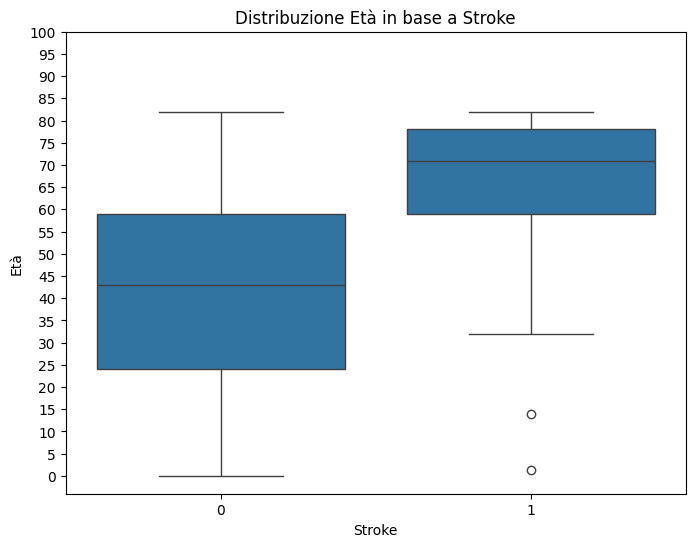

In [14]:
plt.figure(figsize=(8,6))
sns.boxplot(x='stroke', y='age', data=df_stroke)
plt.yticks(np.arange(0, 101, 5))

plt.title("Distribuzione Età in base a Stroke")
plt.xlabel("Stroke")
plt.ylabel("Età")
plt.show()

Come si nota dal box plot:
- Per i pazienti **senza ictus (`stroke = 0`)**:
  - La mediana dell’età è circa intorno ai 40-45 anni.
  - Il 50% centrale dei dati (intervallo interquartile) va da circa 25 a 60 anni.
  - L’età minima si avvicina a 0 anni, mentre quella massima supera gli 80 anni.
  - La distribuzione è abbastanza ampia e copre una vasta fascia d’età.

- Per i pazienti **con ictus (`stroke = 1`)**:
  - La mediana dell’età è molto più alta, attorno ai 70-75 anni.
  - Il 50% centrale dei dati si trova tra circa 60 e 80 anni.
  - Gli estremi variano da circa 30 a oltre 80 anni.
  - Sono presenti alcuni outlier con età molto basse (vicino a 0 o poco più), che potrebbero rappresentare casi particolari o errori nei dati.

Possiamo osservare che:

- L’età media dei pazienti che hanno avuto un ictus è significativamente più alta rispetto a quelli che non lo hanno avuto.
- L’ictus tende a colpire principalmente persone anziane (oltre i 60 anni).
- La distribuzione degli anziani senza ictus è più ampia e comprende anche pazienti giovani.
- Gli outlier nei pazienti con ictus meritano attenzione per verificare la correttezza dei dati o per studiare casi atipici.


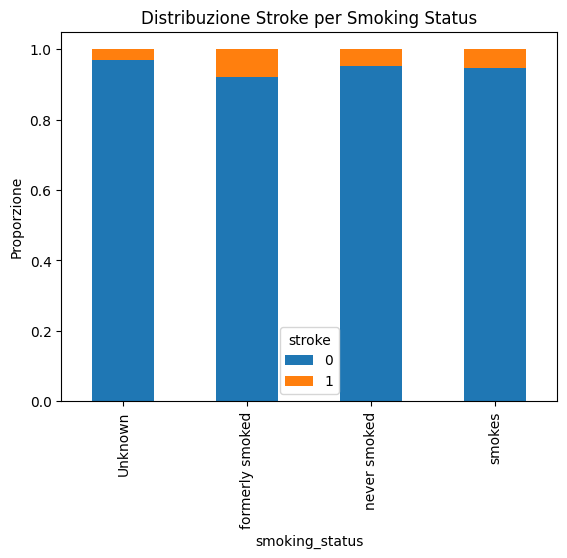

In [15]:
pd.crosstab(df_stroke['smoking_status'], df_stroke['stroke'], normalize='index').plot(kind='bar', stacked=True)
plt.title("Distribuzione Stroke per Smoking Status")
plt.ylabel("Proporzione")
plt.show()

Il grafico mostra la distribuzione proporzionale dei casi di ictus (`stroke`) in base allo stato di fumo (`smoking_status`).  
Si nota che la maggior parte delle persone in ogni categoria non ha avuto un ictus (barra blu), mentre la proporzione di persone con ictus (barra arancione) è relativamente bassa e simile tra le diverse categorie di fumo.  
Non emergono differenze evidenti nel rischio di ictus in relazione allo stato di fumatore, anche se la categoria "formerly smoked" mostra una leggera maggioranza relativa di casi con ictus rispetto agli altri gruppi.

Queste osservazioni sono però sicuramente condizionate dall'alto sbilanciamento del dataset e, considerando soprattuto come l'essere (o esser stato) fumatore costituisca uno dei maggiori fattori di rischio di ictus [[source](https://pmc.ncbi.nlm.nih.gov/articles/PMC2928253/)], risultano fuorvianti.

Dobbiamo quindi sottolineare nuovamente come, il trattare lo sbilanciamento di *Stroke Prediction Dataset,* costituisca una priorità per ottenere un modello di classificazione accettabile.

# Preprocessing di Stroke Risk Dataset

In [16]:
from sklearn.impute import KNNImputer

Creiamo una seconda istanza di df_stroke con lo scopo di poter applicare le trasformazioni necessarie manetenendo una copia del dataset originale.

In [17]:
df_stroke_processed = df_stroke.copy()

Rimozione della colonna `id`.

In [18]:
df_stroke_processed.drop(columns=['id'], inplace=True)
print(df_stroke_processed.columns)

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')


Le righe con `gender="Other"` sono state rimosse poiché rappresentano una categoria rara (solo 1 riga su 5.110) e possono introdurre rumore nel modello di classificazione.

In [19]:
print("Valori unici in 'gender' prima della rimozione:", df_stroke_processed['gender'].unique())
df_stroke_processed = df_stroke_processed[df_stroke_processed['gender'] != 'Other']
print("Valori unici in 'gender' dopo la rimozione:", df_stroke_processed['gender'].unique())
print("Numero di righe dopo la rimozione:", len(df_stroke_processed))

Valori unici in 'gender' prima della rimozione: ['Male' 'Female' 'Other']
Valori unici in 'gender' dopo la rimozione: ['Male' 'Female']
Numero di righe dopo la rimozione: 5109


# Definizione della variabile target

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Definiamo le variabili:

*   X → Insieme delle variabili indipendenti.
*   y → Variabile target.



In [21]:
X = df_stroke_processed.drop(columns=['stroke'])
y = df_stroke_processed['stroke']

# XGBoost

Partiamo con il convertire le feeture categoriche in feture numeriche attraverso il One-Hot Encoding.

In [22]:
!pip install --quiet xgboost imbalanced-learn scikit-learn pandas

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_fscore_support,
    accuracy_score,
    precision_score,
    recall_score
)

from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline

from xgboost import XGBClassifier

### Separazione delle features

Suddivisione delle features in base al tipo di dato:
- **Categoriche**: Variabili con più categorie (es. tipo di lavoro)
- **Numeriche**: Variabili continue da normalizzare/standardizzare
- **Binarie**: Variabili già in formato 0/1 (non richiedono codifica)  

La separazione facilita trasformazioni differenziate come OneHotEncoder, per features categoriche e StandardScaler, per features numeriche.  

In [24]:
categorical_features = [
    "gender", "ever_married", "work_type",
    "Residence_type", "smoking_status"
]
numeric_features = ["age", "avg_glucose_level", "bmi"]
binary_features  = ["hypertension", "heart_disease"]

print(Fore.YELLOW + f"Features categoriche: {categorical_features}")
print(Fore.CYAN + f"Features numeriche: {numeric_features}")
print(Fore.LIGHTBLUE_EX + f"Features binarie: {binary_features}")

Features categoriche: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
Features numeriche: ['age', 'avg_glucose_level', 'bmi']
Features binarie: ['hypertension', 'heart_disease']


Pipeline composita per gestire in modo differenziato le feature:
- **Numeriche**: Imputazione valori mancanti con KNN (preserva relazioni tra dati) + standardizzazione.
- **Categoriche**: Imputazione con moda + one-hot encoding (crea colonne binarie per ogni categoria).  
- **Binarie**: Mantenute intatte tramite `remainder="passthrough"`.

Il dataset è quindi trasformato con feature omogenee pronte per il modello.

In [25]:
numeric_transformer = Pipeline([
    ("imputer", KNNImputer(n_neighbors=5)),
    ("scaler",  StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe",     OneHotEncoder(handle_unknown="ignore", drop=None))
])

preprocessor = ColumnTransformer([
    ("num",  numeric_transformer, numeric_features),
    ("cat",  categorical_transformer, categorical_features),
], remainder="passthrough", force_int_remainder_cols=False)

### Oversampling e Undersampling

Combinazione di resampling (SMOTEENN) e XGBoost ottimizzato per dati sbilanciati:
- **SMOTEENN**: Tecnica ibrida (oversampling SMOTE + undersampling ENN) per bilanciare le classi
- **XGBoost**: Parametri calibrati per dati medici (alto n_estimators, basso learning_rate)
- **scale_pos_weight**: Bilancia automaticamente il peso della classe positiva (calcolato in base allo sbilanciamento)

Abbiamo utilizzato ImbPipeline invece di Pipeline standard per integrare correttamente il resampling nel flusso.

L'output atteso è un modello addestrato su dati bilanciati, con valutazione su metriche sensibili agli sbilanciamenti (es. AUC-ROC, F1-score).

\begin{align}
  ImbPipeline  (preprocess → SMOTEENN → XGB)
\end{align}

In [26]:
smoteenn = SMOTEENN(random_state=42)

xgb_model = XGBClassifier(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    scale_pos_weight= (y.value_counts()[1] / y.value_counts()[0]) # < 0.001 UNDER SAMPLING inverti lightGBM, gnn
)

pipe = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smoteenn",     smoteenn),
    ("model",        xgb_model)
])

### Addestramento del modello

Split del dataset in training (80%) e test set (20%) preservando la proporzione originale delle classi:  
- **stratify=y**: Garantisce la stessa distribuzione di casi di ictus (classe rara) in entrambi i set  
- **random_state=42**: Riproducibilità dello split  

**Output**: 4 subset (X_train, X_test, y_train, y_test) pronti per l'addestramento e la validazione del modello.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

Addestramento del modello pronto per generare predizioni. Con lo scopo di evitare contaminazioni le trasformazioni vengono apprese solo sul train set.

In [28]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.03,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=800, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

### Visualizzazione dei risultati ottenuti

Calcolo delle probabilità predette e conversione in classi binarie (soglia 0.5):  
- **y_pred_proba**: Probabilità di appartenenza alla classe positiva (ictus) per ogni sample  
- **Soglia 0.5**: Scelta standard ma potrebbe essere ottimizzata in caso di forte sbilanciamento  

**Metriche chiave**:  
- AUC-ROC: Valuta la capacità discriminativa su tutte le soglie (ideale per classi sbilanciate)  
- Classification report: Focus su recall e F1-score per la classe minoritaria (ictus)

In [29]:
def show_report(model, X_test, y_test, threshold=0.5):
  y_pred_proba = model.predict_proba(X_test)[:, 1]
  y_pred = (y_pred_proba >= threshold).astype(int)

  print("AUC-ROC  :", roc_auc_score(y_test, y_pred_proba))
  print(classification_report(y_test, y_pred))
  return y_pred_proba, y_pred

y_pred_proba, y_pred = show_report(pipe, X_test, y_test)

AUC-ROC  : 0.7551234567901234
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       972
           1       0.17      0.14      0.15        50

    accuracy                           0.92      1022
   macro avg       0.56      0.55      0.56      1022
weighted avg       0.92      0.92      0.92      1022



Salvataggio dei risultati in un dict.

In [30]:
def results_to_dict(y_test, y_pred_proba, y_pred, threshold=0.5):
  auc = float(roc_auc_score(y_test, y_pred_proba))
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, zero_division=0)
  recall = recall_score(y_test, y_pred, zero_division=0)
  f1 = f1_score(y_test, y_pred, zero_division=0)

  model_results = {
      'AUC': round(auc, 3),
      'Accuracy': round(accuracy, 3),
      'Precision': round(precision, 3),
      'Recall': round(recall, 3),
      'F1': round(f1, 3)
  }

  return model_results

xgb_results = results_to_dict(y_test, y_pred_proba, y_pred, xgb_model)

Grafico della matrice di confusione per analizzare performance del modello su classi specifiche:  
- **Formato annotazioni**: Valori interi (`fmt='d'`) per chiarezza nella lettura di TP, TN, FP, FN  
- **Colormap**: Scala di blu (`cmap='Blues'`) per enfatizzare differenze nelle celle  

**Aspetto chiave**: Struttura tipica di dataset sbilanciati (alti TN, bassi TP). Utile per identificare falsi negativi (casi di ictus non rilevati), errore critico in contesto medico.

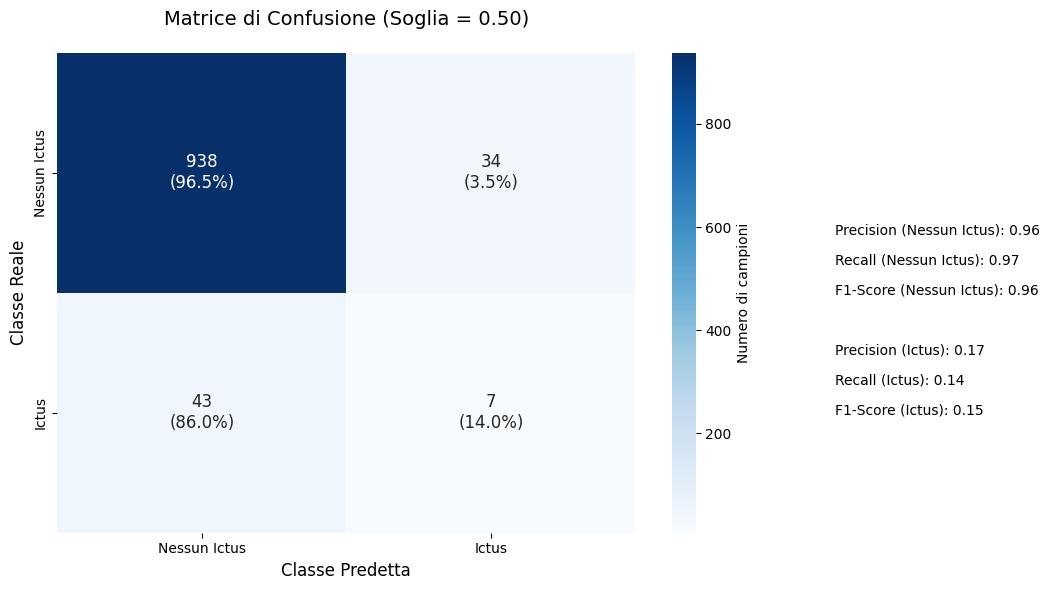

In [31]:
# Funzione per visualizzare una matrice di confusione
def plot_confusion_matrix(y_true, y_pred, threshold=0.5, class_names=["Nessun Ictus", "Ictus"]):
    # Calcola la matrice di confusione
    cm = confusion_matrix(y_true, y_pred)

    # Calcola i valori percentuali
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Crea un'annotazione combinata (valori assoluti + percentuali)
    annot = np.empty_like(cm, dtype=object)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot[i, j] = f"{cm[i, j]}\n({cm_percentage[i, j]:.1f}%)"

    # Calcola precision, recall e F1-score per ogni classe
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)

    # Crea la figura
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=annot, fmt='', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                annot_kws={"size": 12}, cbar_kws={'label': 'Numero di campioni'})

    # Aggiungi titolo e etichette
    plt.title(f"Matrice di Confusione (Soglia = {threshold:.2f})", fontsize=14, pad=20)
    plt.xlabel("Classe Predetta", fontsize=12)
    plt.ylabel("Classe Reale", fontsize=12)

    # Aggiungi metriche come testo accanto alla matrice
    plt.figtext(1.05, 0.6, f"Precision (Nessun Ictus): {precision[0]:.2f}", fontsize=10)
    plt.figtext(1.05, 0.55, f"Recall (Nessun Ictus): {recall[0]:.2f}", fontsize=10)
    plt.figtext(1.05, 0.5, f"F1-Score (Nessun Ictus): {f1[0]:.2f}", fontsize=10)
    plt.figtext(1.05, 0.4, f"Precision (Ictus): {precision[1]:.2f}", fontsize=10)
    plt.figtext(1.05, 0.35, f"Recall (Ictus): {recall[1]:.2f}", fontsize=10)
    plt.figtext(1.05, 0.3, f"F1-Score (Ictus): {f1[1]:.2f}", fontsize=10)

    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_test, y_pred)

Visualizzazione delle performance del modello su tutte le soglie di classificazione:  
- **AUC (Area Under Curve)**: Valore compreso tra 0.5 (probabilità di categorizzare casualmente) e 1 (perfetto). Un AUC >0.8 indica buona capacità discriminativa  
- **Linea tratteggiata**: Rappresenta un classificatore casuale (baseline di confronto)  

**Interpretazione**: Un'area elevata sotto la curva suggerisce che il modello distingue efficacemente i pazienti a rischio, aspetto cruciale per dataset medici sbilanciati.

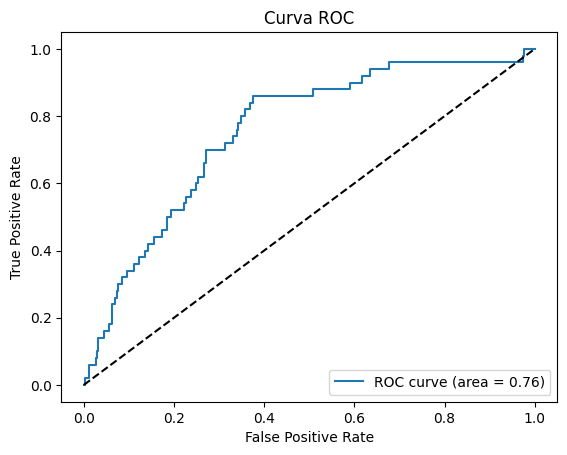

In [32]:
def plot_roc_curve(y_true, y_pred_proba):
  fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
  roc_auc = auc(fpr, tpr)

  plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Curva ROC')
  plt.legend(loc='lower right')
  plt.show()

plot_roc_curve(y_test, y_pred_proba)

### Valutazione del modello XGBoost

| **Metrica** | **Valore** | **Interpretazione** |
|-------------|-----------:|---------------------|
| **AUC-ROC** | **0.76** | Capacità di discriminazione accettabile tra le classi, ma non ottimale; si può migliorare. |
| **Accuracy** | **0.92** | Alta, ma fuorviante a causa dello sbilanciamento. |
| **Classe 0**<br>(non-evento) | Precisione **0.96**<br>Recall **0.97**<br>F1-score **0.96** | Il modello individua quasi tutti i “negativi” e commette pochi falsi positivi. |
| **Classe 1**<br>(evento) | Precisione **0.17**<br>Recall **0.14**<br>F1-score **0.15** | Prestazioni scarse: la maggior parte degli “eventi” non viene riconosciuta (molti falsi negativi). |
| **Macro avg** | **0.56** (precisione/recall/F1) | Media non pesata: riflette lo sbilanciamento e la debolezza sulla classe minoritaria. |
| **Weighted avg** | **0.92** | Media pesata dai campioni: dominata dalla classe 0, quindi poco indicativa per la classe 1. |


Con solo 4.8% esempi positivi, il modello privilegia la classe maggioritaria. Ciò spiega l’alta accuracy ma la bassa F1 per la classe 1.

> **Conclusione:** il modello è affidabile nel riconoscere i non-eventi, ma insufficiente per gli eventi. Serve intervenire su sbilanciamento elevare recall e F1 della classe positiva.


# Catboost

Considerati i risultati insoddisfacenti ottenuti con XGBoost, procediamo a testare un modello alternativo.
CatBoost si distingue generalmente per una gestione più efficace dei dataset contenenti variabili categoriche [[source](https://neptune.ai/blog/when-to-choose-catboost-over-xgboost-or-lightgbm)] e, in molti casi, mostra performance superiori rispetto a XGBoost, specialmente quando il dataset presenta caratteristiche complesse o sbilanciate [[source](https://www.geeksforgeeks.org/handling-imbalanced-classes-in-catboost-techniques-and-solutions/)].

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.1 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier, Pool
from sklearn.preprocessing import LabelEncoder

Applicazione della pipeline, già definita, di preprocessing alle variabili numeriche.

In [ ]:
X[numeric_features] = numeric_transformer.fit_transform(X[numeric_features])

Split del dataset in training (80%) e test set (20%) preservando la proporzione originale delle classi

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

### Oversampling e Undersampling

Processo in 3 fasi per gestire dati categorici con SMOTEENN e CatBoost:
1. **Label Encoding**: Conversione temporanea delle categorie in numeri per permettere il resampling
2. **SMOTEENN**: Applicato sul dataset codificato per bilanciare le classi (combinazione oversampling/undersampling)
3. **Inverse Transform**: Ritorno ai valori originali (stringhe) per sfruttare la gestione nativa delle categorie in CatBoost

La codifica temporanea è necessaria perché SMOTEENN lavora solo su dati numerici, mentre CatBoost beneficia delle categorie stringa per split ottimali.

In [ ]:
X_train_enc = X_train.copy()
encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X_train_enc[col] = le.fit_transform(X_train_enc[col].astype(str))
    encoders[col]   = le

# bilanciamento
smoteenn = SMOTEENN(random_state=42)
X_res, y_res = smoteenn.fit_resample(X_train_enc, y_train)

# decodifica: riportiamo stringhe per CatBoost
for col, le in encoders.items():
    X_res[col] = le.inverse_transform(X_res[col].astype(int))


Conversione dei dati in oggetti Pool per sfruttare le funzionalità native di CatBoost:
- **Train Pool**: Utilizza il dataset bilanciato (X_res, y_res) con categorie in formato stringa
- **Test Pool**: Mantiene il formato originale del test set per una valutazione realistica
- **cat_features**: Specifica esplicita delle colonne categoriche per l'ottimizzazione degli split

In [ ]:
train_pool = Pool(X_res, y_res, cat_features=categorical_features)
test_pool  = Pool(X_test, y_test, cat_features=categorical_features)

Parametri ottimizzati per la predizione di ictus:
- **iterations=500**: Numero elevato di alberi con early stopping (ferma training se non migliora per 100 round)
- **depth=6**: Profondità media-alta per catturare interazioni complesse tra feature mediche
- **scale_pos_weight**: Bilancia automaticamente il peso della classe positiva (ictus) in base allo sbilanciamento originale
- **eval_metric="AUC"**: Ottimizzazione diretta dell'area sotto la curva ROC, metrica robusta per classi rare

**Vantaggio chiave**: CatBoost gestisce nativamente le categorie (specificate in `cat_features`) senza bisogno di one-hot encoding, preservando le relazioni tra variabili categoriche (es. "smoking_status").

In [ ]:
catb_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.03,
    depth=6,
    eval_metric="AUC",
    random_seed=42,
    early_stopping_rounds=100,
    verbose=100,
    scale_pos_weight= (y.value_counts()[1] / y.value_counts()[0])
)

### Addestramento del modello

Esecuzione del training monitorando le performance sul test set:
- **eval_set=test_pool**: Valutazione in tempo reale sullo split di test per evitare overfitting
- **use_best_model=True**: Mantiene l'iterazione con migliore AUC sul test set (non l'ultima)
- **early_stopping_rounds=100**: Interruzione anticipata se nessun miglioramento per 100 iterazioni

Nonostante l'uso del test set per l'early stopping, la valutazione finale va fatta su un validation set separato per evitare ottimizzazione involontaria sui dati di test.  
**Output**: Log di training con AUC aggiornato ogni 100 iterazioni (parametro `verbose=100`), modello ottimizzato salvato automaticamente.

In [ ]:
catb_model.fit(train_pool, eval_set=test_pool, use_best_model=True)

### Visualizzazione dei dati ottenuti

Generazione delle predizioni e calcolo delle metriche di performance:
- **Soglia 0.5**: Scelta standard per classificazione binaria
- **AUC-ROC**: Metrica principale per valutare la capacità discriminativa su tutte le soglie
- **Classification Report**: Focus su recall e F1-score per la classe minoritaria (ictus)

**Scelta tecnica**: Mantenimento della soglia standard 0.5 nonostante lo sbilanciamento iniziale, compensato dall'uso di `scale_pos_weight` durante l'addestramento.  


In [ ]:
threshold_catb = 0.5

y_pred_proba_catb, y_pred_catb = show_report(catb_model, X_test, y_test, threshold=threshold_catb)

Salvataggio dei risultati in un dict.

In [ ]:
catb_results = results_to_dict(y_test, y_pred_proba_catb, y_pred_catb)

Grafico della matrice di confusione.

In [ ]:
plot_confusion_matrix(y_test, y_pred_catb, threshold_catb)

Grafico della curva ROC.

In [ ]:
plot_roc_curve(y_test, y_pred_proba_catb)

### Valutazione del modello CatBoost

| **Metrica** | **Valore** | **Interpretazione** |
|-------------|-----------:|---------------------|
| **AUC-ROC** | **0.78** | Leggero miglioramento nella capacità di discriminazione tra le classi rispetto a XGBoost, ma ancora con margine di miglioramento. |
| **Accuracy** | **0.93** | Alta accuratezza complessiva, comunque influenzata dallo sbilanciamento delle classi. |
| **Classe 0**<br>(non-evento) | Precisione **0.96**<br>Recall **0.97**<br>F1-score **0.96** | Prestazioni molto solide nel riconoscere la classe maggioritaria, con pochi falsi positivi. |
| **Classe 1**<br>(evento) | Precisione **0.19**<br>Recall **0.12**<br>F1-score **0.15** | Leggero miglioramento della precisione rispetto a XGBoost, ma il recall rimane molto basso, indicando che molti eventi vengono ancora non riconosciuti. |
| **Macro avg** | **0.57** (precisione/recall/F1) | Media non pesata, ancora penalizzata dalla difficoltà nella classe minoritaria. |
| **Weighted avg** | **0.92** | Media pesata, dominata dalla classe 0, quindi poco rappresentativa per la classe 1. |


Il modello CatBoost migliora leggermente le metriche di classificazione rispetto a XGBoost, soprattutto nell’AUC-ROC e nella precisione della classe positiva.
Tuttavia, il recall della classe 1 rimane molto basso, suggerendo la necessità di ulteriori strategie per migliorare il riconoscimento degli eventi rari.


> **Conclusione:** CatBoost offre un lieve miglioramento  rispetto a XGBoost, ma rimane fondamentale lavorare sul bilanciamento per migliorare la capacità di rilevare la classe minoritaria.


# LightGBM

Tpicamente LightGBM può riportare performance migliori rispetto a XGBoost e CatBoost nella gestione di dataset di grandi dimensioni [[source](https://kishanakbari.medium.com/xgboost-vs-catboost-vs-lightgbm-a-guide-to-boosting-algorithms-47d40d944dab)].
Non essendo Stroke Risk Dataset considerabile di grandi dimensioni non ci aspettiamo particolari miglioramenti.
Essendo tuttavia LightGBM uno degli algoritmi di Gradient Boosting più utilizzati [[source](https://www.youtube.com/watch?v=-vajbhIfVzs)] decidiamo comunque di dargli una possibilità.

In [ ]:
!pip install lightgbm

In [ ]:
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc

Applicazione della pipeline di preprocessing alle variabili numeriche.

In [ ]:
X[numeric_features] = numeric_transformer.fit_transform(X[numeric_features])

Split del dataset mantenendo la stessa stratificazione.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

Encoding delle variabili categoriche.

In [ ]:
X_train_lgb = X_train.copy()
X_test_lgb = X_test.copy()

Label encoding per le variabili categoriche.

In [ ]:
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    # Fit sul train set e transform sia train che test
    X_train_lgb[col] = le.fit_transform(X_train_lgb[col].astype(str))
    X_test_lgb[col] = le.transform(X_test_lgb[col].astype(str))
    label_encoders[col] = le

Applicazione SMOTEENN per bilanciare il dataset.

In [ ]:
smoteenn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smoteenn.fit_resample(X_train_lgb, y_train)

Creazione dei dataset LightGBM.

Specifichiamo le colonne categoriche per sfruttare la gestione nativa di LightGBM

In [ ]:
categorical_feature_indices = [X_train_resampled.columns.get_loc(col) for col in categorical_features]

train_data = lgb.Dataset(
    X_train_resampled,
    label=y_train_resampled,
    categorical_feature=categorical_feature_indices
)

test_data = lgb.Dataset(
    X_test_lgb,
    label=y_test,
    categorical_feature=categorical_feature_indices,
    reference=train_data
)

Parametri ottimizzati per LightGBM.

In [ ]:
lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.03,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_data_in_leaf': 20,
    'random_state': 42,
    'verbose': -1,
    'scale_pos_weight': ( y.value_counts()[1] / y.value_counts()[0]),
}

Training del modello LightGBM.

In [ ]:
lgb_model = lgb.train(
    lgb_params,
    train_data,
    num_boost_round=800,
    valid_sets=[train_data, test_data],
    valid_names=['train', 'eval'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=100)
    ]
)

Predizioni e valutazione con soglia a 0.5.

In [ ]:
threshold_lgb = 0.5

y_pred_proba_lgb = lgb_model.predict(X_test_lgb, num_iteration=lgb_model.best_iteration)
y_pred_lgb = (y_pred_proba_lgb >= threshold_lgb).astype(int)

print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba_lgb):.4f}")
print(f"Numero di iterazioni ottimali: {lgb_model.best_iteration}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lgb))

Salvataggio dei risultati in un dict.

In [ ]:
lgb_results = results_to_dict(y_test, y_pred_proba_lgb, y_pred_lgb)

Grafico matrice di confusione.

In [ ]:
plot_confusion_matrix(y_test, y_pred_lgb, threshold_lgb)

Grafico curva roc.

In [ ]:
# Curva ROC
plot_roc_curve(y_test, y_pred_proba_lgb)

### Valutazione del modello LightGBM

| **Metrica** | **Valore** | **Interpretazione** |
|-------------|-----------:|---------------------|
| **AUC-ROC** | **0.786** | Leggero miglioramento nella capacità di discriminazione rispetto ai modelli precedenti, ma ancora con margine di miglioramento. |
| **Accuracy** | **0.94** | Alta accuratezza complessiva, influenzata dallo sbilanciamento delle classi (972 vs 50 esempi). |
| **Classe 0**<br>(non-evento) | Precisione **0.95**<br>Recall **0.98**<br>F1-score **0.97** | Ottime prestazioni nel riconoscere la classe maggioritaria, con pochi falsi negativi. |
| **Classe 1**<br>(evento) | Precisione **0.19**<br>Recall **0.08**<br>F1-score **0.11** | Prestazioni ancora molto basse per la classe minoritaria, con un recall particolarmente basso, il che indica che molti eventi positivi non vengono rilevati. |
| **Macro avg** | **0.57** (precisione/recall/F1) | Media non pesata che riflette la difficoltà nel riconoscere la classe minoritaria. |
| **Weighted avg** | **0.92 - 0.94** | Media pesata dominata dalla classe 0, quindi poco rappresentativa per la classe 1. |

LightGBM raggiunge il valore più alto di AUC-ROC tra i modelli provati, dimostrando una buona capacità di discriminazione globale.  
La precisione e il recall della classe positiva restano però molto bassi, evidenziando una difficoltà nel riconoscere gli esempi della classe minoritaria.  
L’elevata accuratezza è condizionata dallo sbilanciamento, quindi non riflette l’effettiva performance sulle classi.  

> **Conclusione:** Nonostante l’AUC-ROC leggermente superiore, i valori più bassi di recall e F1-score indicano che LightGBM offre prestazioni peggiori nel riconoscimento della classe minoritaria rispetto agli altri modelli provati. Questo significa che il modello fatica maggiormente a individuare i veri positivi, compromettendo l’efficacia in scenari dove è fondamentale catturare la minoranza.

LightGBM offre la possibilità di ottenere la feature importance ovvero quanto ogni feature di input contribuisce alle predizioni del modello.

In [ ]:
# Ottiene feature importance
importance = lgb_model.feature_importance(importance_type='gain')
feature_names = X_train_resampled.columns

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values('importance', ascending=False)

print(feature_importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(10, 8))
top_features = feature_importance_df.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance (Gain)')
plt.title('Top 15 Feature Importance - LightGBM')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

La feature importance risulta plausibile in quanto

*   età superiore ai 50 anni
*   presenza di diabete
*   stile di vita non sano e un alto livello di colesterolo, spesso associati ad un alto valore di bmi

sono considerate tra le maggiori cause di ictus [[link text](https://www.nhs.uk/conditions/stroke/causes/)].

# Risultati ottenuti attraverso XGBoost, CatBoost e LightGBM

Riportiamo i risultati sulla classe postivia (stroke=1) ottenuti attraverso i modelli XGBoost, CatBoost e LightGBM.

In [ ]:
results = {
    'XGBoost':   xgb_results,
    'CatBoost':  catb_results,
    'LightGBM':  lgb_results
}

df = pd.DataFrame(results).T

# Highlight max value in each column with green background
styled_df = df.style.highlight_max(axis=0, color='blue')

print(Fore.BLUE + "Valore più alto evidenziato per colonna.")
styled_df

### Commento sui risultati dei modelli

- **AUC (Area Under the ROC Curve):**  
  LightGBM raggiunge il valore più alto (0.786), seguito da CatBoost (0.780) e XGBoost (0.755), indicando che LightGBM ha la migliore capacità globale di discriminazione tra classi.

- **Accuracy:**  
  Anche qui LightGBM primeggia (0.938), con CatBoost (0.932) e XGBoost (0.925) leggermente inferiori. Tuttavia, dato il forte sbilanciamento delle classi, l’accuracy è meno indicativa della capacità di riconoscimento della minoranza.

- **Precision:**  
  CatBoost ha la precisione più alta (0.194), seguita da LightGBM (0.190) e XGBoost (0.171). Questo indica che CatBoost commette meno falsi positivi rispetto agli altri.

- **Recall:**  
  XGBoost ottiene il valore migliore (0.14), seguito da CatBoost (0.12) e LightGBM (0.08). Il recall misura la capacità di riconoscere i veri positivi, e un valore basso in tutti indica una difficoltà generale nel catturare la classe minoritaria.

- **F1-Score:**  
  XGBoost guida con 0.154, CatBoost segue con 0.148, mentre LightGBM è più basso (0.113).

---

### Sintesi
- **XGBoost** mostra un migliore recall e F1, quindi riconosce più esempi positivi, ma con una precisione inferiore e un’AUC più bassa.  
- **CatBoost** si posiziona tra i due, con la precisione più alta ma un recall leggermente inferiore a XGBoost.
- **LightGBM** offre la migliore capacità complessiva di discriminazione e accuratezza, ma ha recall e F1-score più bassi, suggerendo una minore efficacia nel rilevare la classe minoritaria.  

---

### Considerazioni finali
Considerando il forte sbilanciamento del dataset possiamo giungere alla conclusione di come le metriche AUC e Accuracy, nelle quali LightGBM primeggia, non siano particolarmente significative.
I modelli da tenere più in considerazione sono qundi

-   XGBoost → riconosce più falsi positivi ma, in generale, più positivi.
-   CatBoost → riconosce meno falsi positivi ma, in generale, riconosce meno positivi.

In un contesto medico solitamente si tende a prediligere un modello che, a discapito di più falsi positivi, sia in grado di catturare più positivi.
Appare tuttavia evidente come, essendo Precision, Recall e F1-Score molto bassi, nessuno dei modelli trovati sia effettivamente utilizzabile.






# Grid Search

Per trovare un modello che produca risultati accettabili proviamo a trovare i parametri migliori attraversio Grid Search.

Il modello che ha trovato i migliori risultati in termini di Recall e F1-Score sulla classe positiva è XGBoost.
Ci concentriamo quindi ad utilizzare Grid Search su XGBoost.

In [ ]:
!pip install tabulate

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score, recall_score
from tabulate import tabulate

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Creazione di scorer specifici per valutare le performance sul rilevamento degli ictus (classe 1):  
- **precision_scorer**: Misura la percentuale di veri positivi tra i predetti come ictus  
- **recall_scorer**: Misura la capacità di individuare tutti i reali casi di ictus  
- **f1_scorer**: Media armonica tra precision e recall (balance tra falsi positivi e falsi negativi)  

**Scelta importante**: `pos_label=1` focalizza le metriche sulla **classe minoritaria** (ictus), cruciale in contesto medico dove i falsi negativi hanno conseguenze più gravi dei falsi positivi.  


In [ ]:
# Scorers per la classe 1
precision_scorer = make_scorer(precision_score, pos_label=1)
recall_scorer = make_scorer(recall_score, pos_label=1)
f1_scorer = make_scorer(f1_score, pos_label=1)

Definizione dello spazio di ricerca degli iperparametri chiave:
- **Parametri controllo complessità**:
  - `max_depth` (profondità alberi): range 4-8 per bilanciare overfitting/capacità predittiva
  - `subsample` (frazione di dati per ogni albero): valori 0.7-1 per ridurre varianza
- **Parametri ottimizzazione apprendimento**:
  - `learning_rate` (tasso di apprendimento): valori bassi (0.01) per precisione vs alti (0.1) per velocità
  - `n_estimators` (numero alberi): range 100-800 con early stopping


In [ ]:
param_grid = {
    'model__max_depth': [4, 6, 8],
    'model__learning_rate': [0.01, 0.03, 0.1],
    'model__n_estimators': [100, 400, 800],
    'model__subsample': [0.7, 0.8, 1],
}

### Grid Search per massimizzare F1-Score

Ricerca degli iperparametri ottimali con focus sul bilanciamento precision/recall:
- **Scoring multiplo**: Calcola precision, recall e F1 per la classe 1 (ictus) ad ogni fold
- **Refit su F1**: Seleziona il modello con il miglior trade-off tra precision e recall
- **CV stratificata**: Si utilizza una cross validation a 5 split

**Scelte strategiche**:  
- `n_jobs=-1`: Parallelizza la ricerca su tutti i core della CPU  
- `verbose=2`: Log dettagliato per monitorare l'avanzamento  
- Integrazione nella pipeline: Garantisce che SMOTEENN venga applicato solo al training set

Il modello migliore sarà quindi scelto secondo l'F1-Score:

\begin{align}
F1_{score} = 2 \times \frac{Precision \times Recall}{Precision + Recall}
\end{align}
Dove:

 \begin{align}
  Recall = \frac{TP}{TP+FN}
\end{align}



\begin{align}
  Precision = \frac{TP}{TP+FP}
\end{align}







con:
*   ***TP*** → True Positives
*   ***FP*** → False Positives
*   ***TN*** → True Negatives
*   ***FN*** → False Negatives



In [ ]:
grid_search_f1 = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring={'precision': precision_scorer, 'recall': recall_scorer, 'f1': f1_scorer},
    refit='f1',        # Il modello migliore sarà scelto secondo F1 score
    cv=5,
    verbose=2,
    n_jobs=-1,
)

Fit usando dati raw, `pipe` gestisce preprocessing e bilanciamento.
><font color="orange"> **Attenzione ⚠️:** </font>  il seguente codice impiega **dai 7 ai 10 minuti** di esecuzione utilizzando la **GPU T4** di Colab.

In [ ]:
grid_search_f1.fit(X, y)

### Estrazione dei risultati

Estaiamo i parametri che hanno totalizzato una F1-Score maggiore.

In [ ]:
def show_best_results(grid_search):
  print(Fore.GREEN + "Best params:", grid_search.best_params_)
  print(Fore.BLUE + "Best F1 score:", grid_search.best_score_)

  # Precision e recall del miglior modello
  print(Fore.CYAN + "Precision:", grid_search.cv_results_['mean_test_precision'][grid_search.best_index_])
  print(Fore.LIGHTBLUE_EX + "Recall:", grid_search.cv_results_['mean_test_recall'][grid_search.best_index_])

show_best_results(grid_search_f1)

- **Migliori parametri trovati** da GridSearchCV:
  - `learning_rate`: 0.1
  - `max_depth`: 8
  - `n_estimators`: 800
  - `subsample`: 0.7

- **Miglior valore di F1 score ottenuto**: ~ 0.1553  
  Questo significa che la media armonica tra precision e recall per la classe positiva durante la CV è piuttosto bassa, indicando che il modello fatica, nonstante tutto, a bilanciare falsi positivi e falsi negativi.

- **Precisione**: ~ 0.1549  
  Di tutti i campioni predetti come positivi, solo ~15.5% sono effettivamente positivi. Questo indica un alto tasso di falsi positivi.

- **Recall**: ~ 0.1567  
  Il modello ha riconosciuto correttamente solo ~15.7% dei veri positivi, perdendo la maggior parte dei casi positivi.

I parametri trovati non forniscono ancora una buona capacità di classificazione per la classe positiva, come evidenziato dai bassi valori di Precision, Recall e F1.

### Ottimizzazione soglia di classificazione per la classe target

Proviamo ora a trovare la miglior solgia di classificazione per la classe target. Cerchiamo quindi di selezionare la soglia che riesce a dare un F1-Score migliore.

Salvataggio del modello che ha performato meglio e che quindi, ovviamente, contiene i parametri migliori.

In [ ]:
best_model_f1 = grid_search_f1.best_estimator_

Funzione per trovare la soglia ottimale che massimizza una metrica specifica (es. F1-score) per la classe 1 (ictus):

- <u>***Cosa fa:***</u>
  
  Testa `iterations` soglie diverse (da 0 a 1) calcolando precision, recall e F1 per entrambe le classi
- <u>***Logica:***</u>  
  1. **Abbassare la soglia** → più predizioni come 1 (aumenta recall, *riduce falsi negativi*)  
  2. **Alzare la soglia** → meno predizioni come 1 (aumenta precision, *riduce falsi positivi*)

**Scelte tecniche**:  
- `zero_division=0`: Gestisce casi con divisione per zero senza interrompere l'esecuzione  
- Valutazione bilanciata: Mostra metriche per entrambe le classi ma ottimizza solo sulla target (ictus)  
- Formattazione tabellare: Permette confronto rapido del trade-off tra classi

In [ ]:
# best_model         -->     modello che meglio ha performato in Grid Search
# evaluation_metric  -->     metrica di valutazione del modello (F1-score, Recall, Precision)
# target_class       -->     classe (0 / 1) per cui si deve massimizzare l'evaluation model
# iterations         -->     numero di iterazioni corrispondenti al numero di sogli testate
def find_best_thresholds(best_model, evaluation_metric, target_class, iterations, X_test, y_test):
  eval = str(evaluation_metric + f' ({target_class})')

  # Estrzione della colonna contenente le probabilità della target_class
  y_pred_proba = best_model.predict_proba(X_test)[:, target_class]
  thresholds = np.linspace(0, 1, num=iterations)
  results = []

  # Test delle iterations thresholds da 0 a 1
  for thr in thresholds:
      y_pred = (y_pred_proba >= thr).astype(int)

      # Metriche per la classe positiva 1
      prec_1 = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
      rec_1 = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
      f1_1 = f1_score(y_test, y_pred, pos_label=1, zero_division=0)

      # Metriche per la classe negativa 0
      prec_0 = precision_score(y_test, y_pred, pos_label=0, zero_division=0)
      rec_0 = recall_score(y_test, y_pred, pos_label=0, zero_division=0)
      f1_0 = f1_score(y_test, y_pred, pos_label=0, zero_division=0)

      results.append({
          'Threshold': thr,
          'Precision (1)': prec_1,
          'Recall (1)': rec_1,
          'F1-score (1)': f1_1,
          'Precision (0)': prec_0,
          'Recall (0)': rec_0,
          'F1-score (0)': f1_0,
      })

  df = pd.DataFrame(results).round(3)

  # Trova il miglior threshold da eval
  best_idx = df[eval].idxmax()
  best_row = df.loc[best_idx]

  # Tabella contenente i risultati
  table = [
      ['Precision', best_row['Precision (1)'], best_row['Precision (0)']],
      ['Recall',    best_row['Recall (1)'],    best_row['Recall (0)']],
      ['F1-score',  best_row['F1-score (1)'],  best_row['F1-score (0)']],
  ]

  tab = tabulate(table, headers=['Metric', 'Class 1', 'Class 0'], floatfmt=".3f", tablefmt="grid")
  text = f"Best threshold by {eval}: {best_row['Threshold']:.3f}"
  resume = [y_test, y_pred, best_row['Threshold'], y_pred_proba]

  print(Fore.CYAN + text)
  print(tab)
  return resume, text, tab

Dopo una serie di test `iterations=50` risulta essere la scelta migliore.

#### Soglia migliore per F1-score

In [ ]:
resume_f1, text_f1, tab_f1 = find_best_thresholds(best_model_f1, 'F1-score', 1, 50, X_test=X_test, y_test=y_test)

Ottimo miglioramento rispetto ai risultati precedenti.

#### Soglia migliore per Recall

In [ ]:
tab_rec = find_best_thresholds(best_model_f1, 'Recall', 1, 50, X_test=X_test, y_test=y_test)

Pessimo risultato, ovviamente impostando `threshold=0` il modello classificherà tutti i casi come positivi.

#### Soglia migliore per Precision

In [ ]:
tab_prec = find_best_thresholds(best_model_f1, 'Precision', 1, 50, X_test=X_test, y_test=y_test)

Ottimo miglioramento rispetto ai casi precedenti.

# Conclusioni

I risultati migliori sono stati ottenuti ottimizzando la soglia (**threshold**) per le metriche di **F1-Score** e **Precisione**. Tuttavia, è importante notare che la massimizzazione dell'**F1-Score** ha comportato un miglioramento significativo anche nella **Recall** (66.0% contro 58.0%).

In ambito medico, si tende a preferire modelli capaci di intercettare un maggior numero di veri positivi, anche a costo di un aumento ragionevole dei falsi positivi, privilegiando quindi una **Recall** più elevata. Modelli che invece aumentano il numero di falsi negativi, riducendo la capacità di riconoscere positivi, sono considerati meno affidabili e potenzialmente rischiosi.

Di conseguenza, il modello ottimizzato sulla soglia che massimizza l'**F1-Score** rappresenta la scelta migliore per questo contesto, offrendo un bilanciamento efficace tra precisione e capacità di individuare i casi positivi.

### Commento risultati del modello migliore

- **Threshold ottimale** scelto in base al massimo valore di F1-score per la **classe positiva (1)**: **0.429**  

- **Precision**:
  - Classe 1: `0.458` — Il modello è corretto nel 45.8% dei casi in cui predice la classe positiva.  
  - Classe 0: `0.982` — Il modello è molto preciso nel predire la classe negativa, con un tasso di errori molto basso.

- **Recall**:
  - Classe 1: `0.660` — Il modello identifica correttamente il 66.0% dei veri positivi, mostrando una buona capacità di rilevamento dei casi positivi.  
  - Classe 0: `0.960` — Il modello riconosce correttamente il 96.0% dei veri negativi, quindi sbaglia poco nel classificare la classe negativa.

- **F1-score**:
  - Classe 1: `0.541` — Il bilanciamento tra precisione e recall per la classe positiva è moderato, indicando che c’è ancora margine di miglioramento.  
  - Classe 0: `0.971` — Ottimo bilanciamento per la classe negativa, con prestazioni molto solide.



### Confronto con i risultati ottenuti prima di Grid-Search

In [ ]:
print(Fore.BLUE + "Valore più alto evidenziato per colonna.")
styled_df

In [ ]:
print(Fore.GREEN + text_f1)
print(tab_f1)

Mettendo a confronto le tabelle, si possono notare miglioramenti significativi nel riconoscimento della **classe positiva** dopo l'applicazione di Grid Search e l'ottimizzazione della soglia per l'**F1-Score**.

In particolare, considerando i migliori risultati ottenuti tra XGBoost, CatBoost e LightGBM (prima tabella):

- **Precisione**: da **0.194** *(CatBoost)* a **0.458,** con un aumento di <font color='green'>**+0.264**</font>
- **Recall**: da **0.140** *(XGBoost)* a **0.660,** con un aumento di <font color='green'>**+0.520**</font>
- **F1-Score**: da **0.154** *(XGBoost)* a **0.541,** con un aumento di <font color='green'>**+0.387**</font>


In [ ]:
plot_confusion_matrix(resume_f1[0], (resume_f1[3]>=0.041).astype(int), 0.041)

In [ ]:
plot_roc_curve(resume_f1[0], resume_f1[3])

Confrontando la matrice di confusione e la curva roc appena ottenute con quellle trovate in precedenza con **XGBoost, CatBoost** e **LightBoost** i miglioramenti sono apprezzabili.
Confrontando i due grafici, prendendo come riferimento XGBoost:
- <u>***Matrice di confusione***</u>
  * **Veri Negativi** → da **96.5%** a **96.0%,** perdita di <font color='orange'>-0.5%</font>
  * **Falsi Negativi** → da **86.0%** a **34.0%,** diminuzione del <font color='green'>**-52.0%**</font>
  * **Veri Positivi** → da **14.0%** a **66.0%,** aumento del <font color='green'>**+52.0%**</font>
  * **Falsi Positivi** → da **3.5%** a **4.0%,** perdita di <font color='orange'>-0.5%</font>

A fronte di un peggioremanto dello 0.5% nel classificare i reali negativi, che ha portato ad un aumento dei falsi positivi del 0.5%, **il modello è migliorato del 52% a riconoscere i reali positivi.**
Questo piccolo trade off è assolutamente conveniente, soprattutto considerando l'ambito medico in cui opera il modello.

- <u>***Curva Roc***</u>
  * Area sotto la curva passata da **0.76** a <font color='cyan'>**0.95**</font>, aumento di <font color='green'>**0.19**</font>
  * L'area sotto la curva supera ora abbondantemente la soglia di <font color='yellow'>**0.80**</font>. Possiamo quindi concludere, <u>sempre tenendo in considerazione i valori non accettabili di Recall, F1-Score e Precision,</u> che la **capacità discriminativa** del modello trovato sia **buona.**

### Suggerimenti per migliorare ulteriormente il modello

- **Bilanciamento dati:** provare ad utilizzare tecniche differenti da SMOTEENN come ADASYN.
- **Feature engineering:** esplorare nuove feature, trasformazioni o selezioni di feature che possano migliorare la capacità predittiva del modello.
- **Ottimizzazione iperparametri:** estendere la ricerca includendo più parametri o usando tecniche più sofisticate come Bayesian Optimization o Hyperband.
- **Modelli ensemble:** combinare diversi modelli (ad esempio stacking di XGBoost, LightGBM e CatBoost) per sfruttare punti di forza complementari.
- **Threshold tuning:** continuare a esplorare soglie diverse e metriche personalizzate in base al contesto applicativo.
- **Nested cross-validation:** utilizzare Nested cross-validation  per avere una stima più robusta delle performance del modello.
- **Generazione sintentica di dati:** utilizzare un LLM per generare dati appartenenti alla classe minoritaria per bilanciare utlteriormente il training set.

Sono soddisfatto dei risultati ottenuti perché il modello, grazie all'ottimizzazione della soglia e alla ricerca degli iperparametri, ha mostrato un significativo miglioramento nella capacità di riconoscere correttamente la classe positiva, aumentando sia precisione che recall in modo equilibrato. Il progetto, partendo dai suggerimenti appena citati, rimane comunque ampliabile e migliorabile in futuro.


# Analisi Stroke Prediction Dataset V2

In questa sezione si analizza la **seconda versione** di ***Stroke Prediction Dataset.***

<font color="lightgreen"> Il dataset è reperibile qui </font>[Kaggle](https://www.kaggle.com/datasets/mahatiratusher/stroke-risk-prediction-dataset-v2).


### Data Exploration

In [ ]:
df_stroke_v2.head()

Il dataset *Stroke Prediction Dataset V2* contiene le seguenti feature, come evidenziato dalla prima visualizzazione:

- `age:` età del paziente espressa in anni.
- `gender:` genere del paziente (Female/Male).
- `chest_pain:` presenza o assenza di dolore toracico (binaria, 0/1).
- `high_blood_pressure:` presenza o assenza di ipertensione (binaria, 0/1).
- `irregular_heartbeat:` presenza o assenza di battito cardiaco irregolare (binaria, 0/1).
- `shortness_of_breath:` presenza o assenza di respiro corto (binaria, 0/1).
- `fatigue_weakness:` presenza o assenza di affaticamento o debolezza (binaria, 0/1).
- `dizziness:` presenza o assenza di vertigini (binaria, 0/1).
- `swelling_edema:` presenza o assenza di gonfiore o edema (binaria, 0/1).
- `neck_jaw_pain:` presenza o assenza di dolore a collo e mandibola (binaria, 0/1).
- `excessive_sweating:` presenza o assenza di sudorazione eccessiva (binaria, 0/1).
- `persistent_cough:` presenza o assenza di tosse persistente (binaria, 0/1).
- `nausea_vomiting:` presenza o assenza di nausea o vomito (binaria, 0/1).
- `chest_discomfort:` presenza o assenza di fastidio al petto (binaria, 0/1).
- `cold_hands_feet:` presenza o assenza di mani e piedi freddi (binaria, 0/1).
- `snoring_sleep_apnea:` presenza o assenza di russamento o apnea notturna (binaria, 0/1).
- `anxiety_doom:` presenza o assenza di ansia o sensazione di morte imminente (binaria, 0/1).
- `stroke_risk_percentage:` percentuale stimata di rischio di ictus (variabile continua da 0 a 100).
- `at_risk:` variabile target binaria che indica se il paziente è considerato a rischio di ictus (1) o meno (0).

Si può subito apprezzare come questa versione del dataset sia più dettagliata della precedente:



*   ***Stroke Prediction Dataset:*** contiene 12 colonne di cui **11 colonne significative** e 1 colonna `id` da eliminare
*   ***Stroke Prediction Dataset V2:*** contiene 19 colonne di cui **18 significative** e colonna `stroke_risk_percentage` da eliminare
Notiamo, inoltre, come la seconda versione del dataset contenga features quali `anxiety_doom` e `snoring_sleep_apnea` denotando una particolare attenzione anche per lo stile di vita dei pazienti.

In [ ]:
bins = 20
counts, bin_edges = np.histogram(df_stroke_v2['age'], bins=bins)
bar_width = bin_edges[1] - bin_edges[0]
plt.figure(figsize=(10, 6))

for i, count in enumerate(counts):
    color = 'skyblue' if i % 2 == 0 else 'blue'

    plt.bar(bin_edges[i], count, width=bar_width, align='edge', color=color, edgecolor='black')

plt.title('Age Distribution', fontsize=16)
plt.ylabel('Frequency', fontsize=12)

plt.gca().spines[['top', 'right']].set_visible(False)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Il grafico mostra la distribuzione dell’età, i due colori servono solamente per distinguere meglio le classi.  
Si osserva che la maggior parte dei dati si concentra tra i 25 e i 45 anni, con una leggera differenza nella forma delle distribuzioni tra i gruppi.  
I soggetti over 55, che raddoppiano la probabilità di ictus ogni 10 anni [[source](https://www.cdc.gov/stroke/risk-factors/index.html)], sono poco rappresenatati.


In [ ]:
figsize = (12, 1.2 * len(df_stroke_v2['gender'].unique()))
plt.figure(figsize=figsize)
custom_colors = ['pink', 'lightblue']
sns.violinplot(df_stroke_v2, x='age', y='gender', hue='gender', inner='box', palette=custom_colors, legend=False)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.show()

La distribuzione dell'età tra i due sessi è sostanzialmente la stessa e con una mediana tra i 35-40 anni.

In [ ]:
import plotly.express as px

In [ ]:
df_sampled = df_stroke_v2
df_sampled['symptom_score'] = df_stroke_v2[['chest_pain', 'high_blood_pressure', 'irregular_heartbeat', 'shortness_of_breath']].sum(axis=1)
df_sampled['at_risk'] = df_sampled['at_risk'].astype(str)
df_sampled = df_sampled.sample(frac=0.1, random_state=42)

color_map = {'0': 'green', '1': 'red'}

fig = px.scatter_3d(df_sampled,
                    x='age',
                    y='stroke_risk_percentage',
                    z='symptom_score',
                    color='at_risk',
                    color_discrete_map=color_map,
                    opacity=1,
                    size_max=3,
                    labels={'age':'Età', 'stroke_risk_percentage':'Rischio (%)', 'symptom_score':'Sintomi'},
                    title='Distribuzione 3D Età, Rischio e Sintomi')

fig.update_traces(marker=dict(size=4))
fig.update_layout(scene_camera=dict(eye=dict(x=1.5, y=1.5, z=1)))
fig.show()

Il grafico rappresenta la distribuzione tridimensionale dei pazienti in base a tre variabili:  
- **Età** (asse X)  
- **Percentuale di rischio di ictus** (asse Y)  
- **Numero di sintomi rilevati** (asse Z)

I punti sono colorati in base alla variabile target `at_risk`:  
- Verde indica pazienti non a rischio (0)  
- Rosso indica pazienti a rischio (1)

Possiamo osservare che:

- I pazienti a rischio (punti rossi) tendono a concentrarsi in aree con età più alta e con un maggior numero di sintomi.  
- La percentuale di rischio stimata è mediamente più elevata nei pazienti a rischio, come ci si aspetterebbe.  
- Si nota una certa separazione tra i due gruppi, suggerendo che età, sintomi e rischio stimato sono variabili rilevanti per distinguere pazienti a rischio.  
- Alcune sovrapposizioni sono presenti, ma complessivamente il grafico aiuta a visualizzare la relazione multidimensionale tra queste variabili e il rischio di ictus.

>  **Disclaimer:**
* Il numero di sintomi rilevati è stato calcolato semplicemente come somma di alcuni sintomi che compaiono nel paziente in considerazione.
* Per rendere la visualizzazione dei punti più semplice il grafico è stato disegnato prendendo in considerazione un sample del dataset originale. Solamente il 10% dei pazienti, presi casualmente dal dataset originale, sono stati rappresentati.


In [ ]:
df_stroke_v2.describe()

Si pone l’attenzione su una serie di dati:

1. <u>**Dimensione e completezza:**</u>  
   * Il dataset contiene 35.000 campioni completi senza valori mancanti evidenti.
   * A differenza del dateset precedente che ne conteneva solamente 5110 con 201 incompleti.

2. <u>**Distribuzione dell’età:**</u>  
   * Età media circa 38.6 anni con un range da 18 a 86 anni.  
   * Mediana a 37 anni.

3. <u>**Presenza di sintomi e fattori di rischio:**</u>  
   * Le variabili binarie (es. `chest_pain`, `high_blood_pressure`) mostrano valori medi tra 10% e 25%, indicando una prevalenza di assenza di sintomi.  
   * La deviazione standard intorno a 0.3-0.4 è coerente con variabili binarie sbilanciate.

4. <u>**Rischio stimato di ictus:**</u>  
   * Media al 44.5%, con valori che variano da 1.5% fino al 100%.  
   * Il 75% dei campioni ha rischio inferiore a circa 64.5%.

5. <u>**Punteggio sintomi aggregato:**</u>  
   * Media molto bassa (0.69) e massimo 4, indicando che la maggior parte dei soggetti presenta pochi sintomi rilevanti.

6. <u>**Features Numeriche**</u>
  * Solamente la colonna `gender` presenta features categoriche.


In [ ]:
target_balance('at_risk', df_stroke_v2)

In [ ]:
sns.countplot(x='at_risk', data=df_stroke_v2)
plt.title("Distribuzione Target Stroke")
plt.show()

Il dataset è leggermente sbilanciato verso la classe negativa.



*   **at_risk=0** → 63.18%
*   **at_risk=1** → 36.82%

Utilizzare delle tecniche di bilanciamento potrebbe essere necessario.


# Preprocessing

L'unica colonna non necessaria per la costruzione di un modello di classificazione è `stroke_risk_percentage`.

In [ ]:
df_stroke_v2_processed = df_stroke_v2.drop(columns=['stroke_risk_percentage'])

Per poter utlizzare con facilità un qualsiasi modello di classificazione convertiamo la colonna `gender` da testuale a binaria.

In [ ]:
df_stroke_v2_processed['gender'] = df_stroke_v2_processed['gender'].map({'Female': 0, 'Male': 1})
df_stroke_v2_processed.head(3)

Conversione della colonna target da stringa a intero.

In [ ]:
df_stroke_v2_processed['at_risk'] = df_stroke_v2_processed['at_risk'].astype(int)
df_stroke_v2_processed['at_risk'].head(3)

# Definizione variabile target

In [ ]:
X = df_stroke_v2_processed.drop(columns=['at_risk'])
y = df_stroke_v2_processed['at_risk']
scale_pos_weight = (y.value_counts().iloc[1] / y.value_counts().iloc[0])

# XGBoost

In [ ]:
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

Imposto gli stessi parametri della prima sezione.

In [ ]:
xgb_v2 = XGBClassifier(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    scale_pos_weight=scale_pos_weight
)

Esecuzione del training del modello monitorando le performance su eval_set per spottare un possibile overfitting.
> Il parametro verbose è impostato a **False** per mantenere un output pulito.

In [ ]:
eval_set = [(X_train_v2, y_train_v2), (X_test_v2, y_test_v2)]
xgb_v2.fit(X_train_v2, y_train_v2, eval_set=eval_set, verbose=False)

In [ ]:
threshold_xgb = 0.5
y_pred_proba_v2, y_pred_v2 = show_report(xgb_v2, X_test=X_test_v2, y_test=y_test_v2)

I risultati mostrano dei valori troppo vicini all'1 per essere convincenti.

*   **AUC** → <font color="yellow">99.9996%</font> è un valore praticamente perfetto e decisamente troppo alto per non destare sospetti
*   **Recall, Precision e F1-Score** → <font color="yellow">da 97% a 100%</font> sia nella classe positiva che negativa, sono risultati impensabili in un modello reale

Questi valori sono praticamente irraggiungibili per un modello di classificazione reale.
> <font color="orange"> **Problema ⚠️:**</font> Il modello mostra forti segnali di <font color="red">**Overfitting**</font> oppure di <font color="red"> **Data Leakage.**</font>

Bisogna investigare per risolvere il problema e rendere il modello efficace anche per applicazioni reali.



# Troubleshooting

Analisi dell'andamento della AUC sia sul training set che sul test set.

In [ ]:
results = xgb_v2.evals_result()

# Plot training and validation error (auc)
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

# Plot training and validation auc
plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['auc'], label='Train Auc')
plt.plot(x_axis, results['validation_1']['auc'], label='Validation Auc')

# Adding labels and title
plt.title('XGBoost Auc - Training vs Validation')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Auc')
plt.legend()

# Show the plot
plt.show()

Dal grafico si nota che:
- **Entrambe le curve crescono rapidamente nelle prime iterazioni**, raggiungendo valori molto alti già intorno alle 100-200 iterazioni.  
- **La curva di training AUC (in rosa) raggiunge quasi il valore massimo di 1.0**, indicando che il modello si adatta molto bene ai dati di training.  
- **La curva di validation AUC (in marrone) segue da vicino quella di training**, raggiungendo valori molto elevati (vicino a 0.999), il che indica un'eccellente capacità di generalizzazione sui dati di validazione.  
- La differenza tra le due curve è minima e si mantiene costante, suggerendo un **bassissimo rischio di overfitting**.  
- Dopo circa 200-300 iterazioni, le curve si stabilizzano, indicando che il modello ha raggiunto il massimo apprendimento utile e ulteriori iterazioni portano a miglioramenti marginali o nulli.

Il problema non sembra quindi stare nell'**Overfitting** ma, probabilmente, nel <font color="red">**Data Leakage.**</font>

### Investigazione sul Data Leakage

Se il modello è in data leakage significa che sta utilizzando informazioni, disponibili durante il training, che non saranno però disponibili in un utilizzo rale [[source](https://www.ibm.com/think/topics/data-leakage-machine-learning)].
Il modello potrebbe quindi aver individuato una feature, o una serire di feature, che sostanzialmente rivelano il target.
> Osservando il grafico soprastante è verosimile pensare come il modello possa aver individuato questa cheat feature intorno all'iterazione 100 (intorno in cui entrambe le curve iniziano a separarsi).

In [ ]:
from xgboost import plot_importance

Un primo passo per trovare le 'cheat features' sta nel verificare la feature importance di XGBoost.

In [ ]:
def feature_importance_plot(model=xgb_v2, bar_color='salmon'): # Added bar_color parameter
  plt.figure(figsize=(10, 8))
  ax = plot_importance(model, max_num_features=15, importance_type='gain')
  plt.title('Feature Importance (Gain)')

  # Iterate through the bars and set their color
  for bar in ax.patches:
      bar.set_color(bar_color)

  plt.tight_layout()
  plt.show()

feature_importance_plot()

Si può notare come le feature `symptom_score` e `age` costituiscano, di gran lunga, le feature che il modello considera maggiormente per effettuare le predizioni. E' probabile che la cheat feature si nasconda proprio in queste colonne, concentriamo quindi l'attenzione su queste due classi.

### Controllo di **symptom_score**

La mia strategia consiste nell'addestrare nuovamene il modello eliminando la colonna `symptom_score` per poi misurare la potenziale perdita delle performance.

In [ ]:
X_no_symp = X.drop(columns=['symptom_score'])
X_train_no_symp, X_test_no_symp, y_train_no_symp, y_test_no_symp = train_test_split(
    X_no_symp, y, test_size=0.3, stratify=y, random_state=42
)

In [ ]:
eval_set = [(X_train_no_symp, y_train_no_symp), (X_test_no_symp, y_test_no_symp)]
xgb_v2.fit(X_train_no_symp, y_train_no_symp, eval_set=eval_set, verbose=False)

In [ ]:
y_pred_proba_no_symp, y_pred_no_symp = show_report(xgb_v2, X_test=X_test_no_symp, y_test=y_test_no_symp)

Le prestazioni sono sostanzialmente rimaste invariate.

*   **AUC** → rimasto sostanzialmente invariato, non è plausibile
*   **Precision, Recallm F1-Score** → calate in generale ma di pochissimo

Questi valori indicano come il data leakage non sia stato provocato da `symptom_score`.


In [ ]:
results = xgb_v2.evals_result()

# Plot training and validation error (auc)
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

# Plot training and validation auc
plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['auc'], label='Train Auc')
plt.plot(x_axis, results['validation_1']['auc'], label='Validation Auc')

# Adding labels and title
plt.title('XGBoost Auc - Training vs Validation')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Auc')
plt.legend()

# Show the plot
plt.show()

Il grafico delle curve AUC è rimasto sostanzialmente invariato.

In [ ]:
feature_importance_plot()

La feature `high_blood_pressure` ha assunto una grande importanza passando dalla nona posizione alla seconda, questo posizionamento, essendo la pressione alta uno dei maggiori fattori di rischio per l'ictus [[source](https://www.cdc.gov/stroke/risk-factors/index.html)], è assolutamente realistico. La feaure `age` diventa invece prima per importanza.

### Controllo **age**

Rimozione colonna `age`.

In [ ]:
X_no_age = X.drop(columns=['age'])
X_train_no_age, X_test_no_age, y_train_no_age, y_test_no_age = train_test_split(
    X_no_age, y, test_size=0.3, stratify=y, random_state=42
)
xgb_v2_no_age = xgb_v2
xgb_v2_no_age.fit(X_train_no_age, y_train_no_age)

In [ ]:
y_pred_proba_no_age, y_pred_no_age = show_report(xgb_v2_no_age, X_test=X_test_no_age, y_test=y_test_no_age)

Il modello presenta performance peggiori, rispetto a quello con la colonna `age`, ma comunque accettabili e soprattuto plausibili per un applicativo medico.

In particolare:

*   **AUC** → 93.373% scende di poco più del <font color="orange">**6%,**</font> rimanendo comunque ottima.
*   **Precision, Recall e F1-Score** → valori compresi tra il <font color="green"> **72%** </font> e l' <font color="green">**90%**,</font> risultando essere plausibili.



In [ ]:
results = xgb_v2_no_age.evals_result()

# Plot training and validation error (auc)
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

# Plot training and validation auc
plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['auc'], label='Train Auc')
plt.plot(x_axis, results['validation_1']['auc'], label='Validation Auc')

# Adding labels and title
plt.title('XGBoost Auc - Training vs Validation')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Auc')
plt.legend()

# Show the plot
plt.show()

Anche in questo caso il grafico delle curve AUC è rimasto sostanzialmente invariato.

In [ ]:
plt.figure(figsize=(10, 8))

report_dict = classification_report(y_test_v2, y_pred_v2, output_dict=True)
report_dict_no_age = classification_report(y_test_no_age, y_pred_no_age, output_dict=True)

class_label = '1'
if class_label not in report_dict:
    print(f"Warning: Class label '{class_label}' not found in report_dict. Available keys: {report_dict.keys()}")
if class_label not in report_dict_no_age:
    print(f"Warning: Class label '{class_label}' not found in report_dict_no_age. Available keys: {report_dict_no_age.keys()}")

ax1 = plt.subplot(1, 1, 1, projection='polar')

metrics = ['AUC', 'Precision', 'Recall', 'F1-Score', 'Accuracy']

with_age_scores = [
    float(roc_auc_score(y_test_v2, y_pred_proba_v2)),
    float(report_dict[class_label]['precision']),
    float(report_dict[class_label]['recall']),
    float(report_dict[class_label]['f1-score']),
    float(report_dict['accuracy'])
]

without_age_scores = [
    float(roc_auc_score(y_test_no_age, y_pred_proba_no_age)),
    float(report_dict_no_age[class_label]['precision']),
    float(report_dict_no_age[class_label]['recall']),
    float(report_dict_no_age[class_label]['f1-score']),
    float(report_dict_no_age['accuracy'])
]

angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]

with_age_scores += with_age_scores[:1]
without_age_scores += without_age_scores[:1]

ax1.plot(angles, with_age_scores, 'r-', linewidth=2, label='With Age')
ax1.fill(angles, with_age_scores, 'red', alpha=0.25)
ax1.plot(angles, without_age_scores, 'b-', linewidth=2, label='Without Age')
ax1.fill(angles, without_age_scores, 'blue', alpha=0.25)

ax1.set_xticks(angles[:-1])
ax1.set_xticklabels(metrics)
ax1.set_ylim(0, 1)
ax1.set_title('Performance Metrics\nRadar Chart')

ax1.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))

plt.show()

Come mostrato dal grafico soprastante la diminuzione delle performance che si è verificata successivamente alla rimozione della colonna `age` è sostanziale.

In [ ]:
# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create the age groups with corrected labels
df_stroke_v2_processed['age_group'] = df_stroke_v2_processed['age'].apply(
    lambda x: 'Age ≥ 37' if x >= 37 else 'Age < 37'
)

# Create figure with multiple subplots
fig = plt.figure(figsize=(20, 15))

# 1. Stacked bar chart showing absolute numbers
ax2 = plt.subplot(2, 4, 2)

stroke_by_age_group = pd.crosstab(df_stroke_v2_processed['age_group'], df_stroke_v2_processed['at_risk'])

stroke_by_age_group.plot(kind='bar', stacked=True, ax=ax2, color=['lightblue', 'salmon'])
ax2.set_title('Stroke Cases by Age Group (Absolute Numbers)')
ax2.set_xlabel('Age Group')
ax2.set_ylabel('Number of Patients')
ax2.legend(['No Stroke', 'Stroke'])
ax2.tick_params(axis='x', rotation=0)

# Add count labels
for container in ax2.containers:
    ax2.bar_label(container, label_type='center')

# Pie chart for Age ≥ 37 group
ax3 = plt.subplot(2, 4, 3)
age_over_or_equal_37 = df_stroke_v2_processed[df_stroke_v2_processed['age'] >= 37]

# Explicitly get counts for 'No Stroke' and 'Stroke' in correct order
stroke_counts_over_or_equal_37 = age_over_or_equal_37['at_risk'].value_counts()
# Assuming 'at_risk' uses 0 for No Stroke and 1 for Stroke, order counts explicitly
counts_37 = [
    stroke_counts_over_or_equal_37.get(0, 0),  # No Stroke
    stroke_counts_over_or_equal_37.get(1, 0)   # Stroke
]

ax3.pie(counts_37, labels=['No Stroke', 'Stroke'],
        autopct='%1.1f%%', startangle=90, colors=['lightblue', 'salmon'])
ax3.set_title(f'Age ≥ 37 Group\n(n={len(age_over_or_equal_37)} patients)')

# Pie chart for Age < 37 group
ax4 = plt.subplot(2, 4, 4)
age_less_37 = df_stroke_v2_processed[df_stroke_v2_processed['age'] < 37]

stroke_counts_less_37 = age_less_37['at_risk'].value_counts()
counts_less_37 = [
    stroke_counts_less_37.get(0, 0),  # No Stroke
    stroke_counts_less_37.get(1, 0)   # Stroke
]

ax4.pie(counts_less_37, labels=['No Stroke', 'Stroke'],
        autopct='%1.1f%%', startangle=90, colors=['lightblue', 'salmon'])
ax4.set_title(f'Age < 37 Group\n(n={len(age_less_37)} patients)')


Dai grafici si deduce che:

* il **61.4%** dei pazienti con età maggiore o uguale alla mediana (37) appartengano alla classe positiva
* solamente il **10.3%** dei pazienti con età inferiore alla mediana appartengono alla classe positiva

La distribuzione della variabile `at_risk` è quindi fortemente sbilanciata e potrebbe essere alla base del **Data Leakage.**

In [ ]:
# Filter only stroke cases
stroke_cases = df_stroke_v2_processed[df_stroke_v2_processed['at_risk'].astype(int) == 1]

# Count stroke cases by age group
stroke_counts_by_age = stroke_cases['age_group'].value_counts()
print(stroke_counts_by_age)
# Calculate percentages relative to total stroke cases
stroke_percentages = (stroke_counts_by_age / stroke_counts_by_age.sum()) * 100

# Plot
plt.figure(figsize=(8, 6))
bars = plt.bar(stroke_percentages.index, stroke_percentages.values, color=['salmon', 'lightblue'])
plt.ylabel('Percentage of Total Stroke Cases (%)')
plt.title('Distribution of Stroke Cases by Age Group')
plt.ylim(0, 100)

# Add percentage labels on bars
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

plt.show()

df_stroke_v2_processed.drop(columns=['age_group'], inplace=True)

Lo sbilanciamento della classe positiva è reso ancora più chiaro da questo grafico.

*   l'**86.6%** di tutti i pazienti con `at_risk=1` hanno età maggiore o uguale alla mediana
*   solamente il 13.4% di tutti i pazienti con `at_risk=1` hanno età minore alla mediana

Eliminare la colonna `age` potrebbe quindi essere la strada corretta da intraprendere.

In [ ]:
plot_confusion_matrix(y_test_no_age, y_pred_no_age, 0.5)

In [ ]:
plot_roc_curve(y_test_no_age, y_pred_proba_no_age)

### Valutazione del modello XGBoost

| **Metrica**                  | **Valore** | **Interpretazione**                                                                                   |
|------------------------------|-----------:|-----------------------------------------------------------------------------------------------------|
| **AUC-ROC**                  | **0.94**   | Ottima capacità di discriminazione tra le classi, indice di un modello efficace nel distinguere casi positivi e negativi. |
| **Accuracy**                 | **0.87**   | Accuratezza complessiva buona, nonostante un certo sbilanciamento tra le classi.                      |
| **Classe 0**<br>(non-evento) | Precisione **0.86**<br>Recall **0.95**<br>F1-score **0.90** | Prestazioni molto solide nel riconoscere la classe maggioritaria, con alta capacità di identificare i veri negativi. |
| **Classe 1**<br>(evento)      | Precisione **0.90**<br>Recall **0.72**<br>F1-score **0.80** | Buona precisione nella classe minoritaria, ma con un recall più basso che indica qualche falso negativo. |
| **Macro avg**                | Precisione **0.88**<br>Recall **0.84**<br>F1-score **0.85** | Media non pesata che riflette un bilanciamento generale delle prestazioni tra le classi.               |
| **Weighted avg**             | Precisione **0.87**<br>Recall **0.87**<br>F1-score **0.87** | Media pesata che rappresenta le prestazioni complessive, tenendo conto della distribuzione delle classi. |

Il modello XGBoost mostra ottime capacità predittive con un buon compromesso tra precisione e richiamo, specialmente nella classe minoritaria, che è spesso critica nei problemi di classificazione sbilanciata.

> **Conclusione:**  
> Il modello fornisce una solida base di partenza per la classificazione del rischio di ictus, ma ulteriori ottimizzazioni o strategie di bilanciamento potrebbero migliorare la rilevazione della classe positiva.


# Random Search

Con lo scopo di migliorare ulteriormente il modello procedo all'ottimizzazione degli iper-parametri di XGBoost.


*   **Random Search** → dato che Stroke Prediction Dataset V2 è più grande del precedente preferisco Random Search invece di Grid Search (anche per variare).
*   **Nested Cross-Validatio** → per ottenere una valutazione migliore rispetto alla cross validation



In [ ]:
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
)
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    roc_auc_score, classification_report, confusion_matrix,
    make_scorer, accuracy_score, precision_score, recall_score, f1_score
)
from xgboost import XGBClassifier
from scipy.stats import uniform, randint
import warnings
warnings.filterwarnings('ignore')

In [ ]:
X_no_age_best = X.drop(columns=['age'])
X_train_no_age_best, X_test_no_age_best, y_train_no_age_best, y_test_no_age_best = train_test_split(
    X_no_age_best, y, test_size=0.2, stratify=y, random_state=42
)

Definizione della distribuzione dei parametri completa (distribuzione utilizzata anche successivamente).

In [ ]:
# Define parameter distributions for random search
param_distributions = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.29),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'colsample_bylevel': uniform(0.6, 0.4),
    'reg_alpha': uniform(0, 2),
    'reg_lambda': uniform(1, 3),
    'min_child_weight': randint(1, 6),
    'gamma': uniform(0, 0.5),
    'scale_pos_weight': uniform(0.5, 1.5)
}

Definizione di una distribuzione dei parametri più corta nel caso in cui si voglia velocizzare l'esecuzione a discapito delle performance.

In [ ]:
param_distributions_small = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(3, 7),
    'learning_rate': uniform(0.05, 0.25),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(1, 2)
}

Dopo diverse prove la configurazione, *k-folds* e *numero di iterazioni,* con il **miglior trade/off** è risultata essere la seguente.

In [ ]:
k_folds = 5
n_iter = 100

Definizione delle strategie di inner e outer cross-validation per la nested-CV.


*   **inner_cv** → usata per il tuning degli iper-parametri nel training fold *(inner loop)*
*   **outer_cv** → usata per l'evaluation finale del modello *(outer loop)*



In [ ]:
inner_cv = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

Metriche di scoring.

In [ ]:
scoring = {
    'f1': 'f1',
   'recall': 'recall',
    'auc': 'roc_auc',
    'accuracy': 'accuracy',
    'precision': 'precision'
}

Definizione della Random Search con **cv=inner_cv**.

In [ ]:
def perform_random_search(param_distributions, metric='f1'):
  random_search = RandomizedSearchCV(
      estimator=xgb_model,
      param_distributions=param_distributions,
      n_iter=n_iter,
      cv=inner_cv,
      scoring=metric,
      n_jobs=-1,
      verbose=1,
      random_state=42,
      return_train_score=True
  )
  return random_search

random_search = perform_random_search(param_distributions)

Valutazione delle performance della random search.

><font color="orange">**Attenzione ⚠️:**</font> questa cella potrebbe impigare fino a 30 minuti per essere eseguita (GPU T4 Colab).

In [ ]:
nested_scores = cross_val_score(
    random_search,
    X_no_age_best,
    y,
    cv=outer_cv,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

Fit della random search.

><font color="orange">**Attenzione ⚠️:**</font> questa cella potrebbe impigare fino a 10 minuti per essere eseguita (GPU T4 Colab).

In [ ]:
random_search.fit(X_no_age_best, y)

Si mostrano i risultai ottenuti dal modello, su dati non visti, durante la nested cross validation.

In [ ]:
print("Nested CV F1 scores:", nested_scores)
print(f"Mean F1 score: {np.mean(nested_scores):.4f}")
print(f"Std deviation: {np.std(nested_scores):.4f}")

In [ ]:
plt.boxplot(nested_scores, vert=False)
plt.title("Nested CV F1 Scores")
plt.xlabel("F1 Score")
plt.show()

Il boxplot mostra la variabilità delle performance del modello misurate con il punteggio F1 durante le iterazioni dell'outer loop della Nested Cross-Validation.  

- La mediana del punteggio F1 si attesta intorno a 0.8175, indicando una buona consistenza delle prestazioni.  
- L’intervallo interquartile (IQR) è piuttosto stretto, segno di una bassa varianza tra i diversi fold.  
- Non sono presenti outlier evidenti, suggerendo che il modello si comporta in modo stabile su tutti i subset testati.  

Questi risultati confermano che il modello generalizza bene e che la fase di tuning è stata efficace.

In [ ]:
y_pred = random_search.predict(X_test_no_age_best)
y_pred_proba = random_search.predict_proba(X_test_no_age_best)

d1, d2 = show_report(random_search, X_test_no_age_best, y_test_no_age_best)

In [ ]:
# Get the best model
best_xgb = random_search.best_estimator_

In [ ]:
resume, text, tab = find_best_thresholds(best_xgb, 'F1-score', 1, 100, X_test=X_test_no_age_best, y_test=y_test_no_age_best)

Per quanto riguarda la classe positivia si nota:

*   **Recall, F1-Score** → lieve miglioramento
*   **Precision** → lieve peggioramento

Il modello non ha subito grossi cambiamenti rispetto alla `threshold=0.5`.



In [ ]:
plot_confusion_matrix(y_test_no_age_best, y_pred, 0.485)

In [ ]:
plot_roc_curve(y_test_no_age_best, y_pred_proba[:, 1])

Confrontando la matrice di confusione e la curva roc appena ottenute con quella trovata in precedenza precedentemente a Random Search i risultati sono apprezzabili.
Confrontando i due grafici:
- <u>***Matrice di confusione***</u>
  * **Veri Negativi** → da **95.4%** a **90.2%,** perdita di <font color='orange'>-5.2%</font>
  * **Falsi Negativi** → da **27.7%%** a **18.5%,** diminuzione del <font color='green'>**-9.2%**</font>
  * **Veri Positivi** → da **72.3%** a **81.5%,** aumento del <font color='green'>**+9.2%**</font>
  * **Falsi Positivi** → da **4.6%** a **9.8%,** perdita di <font color='orange'>-5.2%</font>

A fronte di un peggioremanto del 5.2% nel classificare i reali negativi, che ha portato ad un aumento dei falsi positivi del 5.2%, **il modello è migliorato del 9.2% a riconoscere i reali positivi.**
Questo piccolo trade off è conveniente, soprattutto considerando l'ambito medico in cui opera il modello.

- <u>***Curva Roc***</u>
  * Area sotto la curva rimasta invariata
  * L'area sotto la curva supera abbondantemente la soglia di <font color='yellow'>**0.80**</font>. Possiamo quindi concludere, <u>sempre tenendo in considerazione i valori non accettabili di Recall, F1-Score e Precision,</u> che la **capacità discriminativa** del modello trovato sia **molto buona.**

Si può concludere come il modello prodotto presenti un livello di Recall, Precision e F1-Score accettabili e che, soprattutto considerando i risultati ottenuti con il primo dataset, posssa ritenermi soddisfatto.

### Suggerimenti per migliorare ulteriormente il modello

Per migliorare ulteriormente le prestazioni del modello, si possono considerare le seguenti strategie:

- **Feature Engineering Avanzato**  
  Creare nuove feature o trasformare quelle esistenti per rendere le informazioni più esplicite e utili al modello.

- **Bilanciamento del Dataset**  
  Utilizzare tecniche come **SMOTE**, **undersampling** o **oversampling** per bilanciare la distribuzione delle classi, riducendo il bias verso la classe maggioritaria.

- **Tuning Iperparametri più Esteso**  
  Ampliare lo spazio di ricerca con metodi come **Bayesian Optimization** o aumentare il numero di iterazioni nel Random Search.

- **Ensembling**  
  Combinare più modelli (es. XGBoost, CatBoost, LightGBM) tramite **voting**, **stacking** o **bagging** per migliorare robustezza e generalizzazione.

- **Utilizzo di Modelli Deep Learning**  
  Se i dati lo consentono, provare modelli basati su reti neurali, soprattutto se ci sono feature complesse o dati non strutturati.

- **Cross-Validation più Granulare**  
  Usare tecniche di cross-validation più robuste o stratificate per assicurare una valutazione più stabile.


# Considerazioni finali sul progetto

Mi ritengo molto soddisfatto del progetto appena concluso: nonostante le difficoltà incontrate, sono riuscito a produrre, in entrambi i casi, un modello accettabile, considerando le problematiche dei dataset di partenza.

Ritengo che, come già specificato, ci siano margini, più o meno ampi, per migliorare ulteriormente i modelli di classificazione.

Mi sarebbe piaciuto implementare anche un meccanismo di generazione dei dati (nel training set) utilizzando un LLM, che sarebbe stato particolarmente utile per aumentare le istanze della classe positiva nel primo dataset, cercando così di contenere ulteriormente lo sbilanciamento. Tuttavia, ho deciso di non intraprendere questa strada a causa della presenza di numerose feature numeriche nel dataset Stroke Prediction, che avrebbero richiesto lunghe e attente verifiche successive alla generazione, portando a un notebook probabilmente troppo vasto.

Spero comunque di trovare il tempo necessario per implementare questa funzionalità in futuro.